## Predicting the Relationship Between Student Knowledge Level and Study Habits of Electrical DC Machines

#### Introduction

Our project topic is about student understanding and knowledge of a subject and its relationship with the students' study habits. Knowledge as defined by the Cambridge Dictionary is the "understanding of or information about a subject that you get by experience or study" (Cambridge University Press 2019). Students often employ many different study techniques for different subjects in hopes to gain a full understanding of the topic. Study habits include the time spent studying the subject, repitition of the subject, exam performance in the subject, as well as how the study habits of related subjects impacts the students' knowledge of the goal subject. 

For our project, our question is: "Can we predict the knowledge level of students based off of their study habits?". The dataset that we will use to answer our question is a collection of data obtained from a Ph. D. thesis ("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN"). The data includes information about students’ knowledge of Electrical DC Machines on a ranking from  very_low, low, middle, and high. The dataset also includes information about how long the students spent studying the subject, related subjects, the students’ exam performance in Electrical DC Machines, and the students' exam performance in related subjects - all were ranked on a scale of 0-1. Study habits are a great predictor for overall academic performance and can thus be used to evaluate the quality of education at institutions (Jafari 2019). For our project, we plan to predict the knowledge level (UNS) of the users of Electrical DC Machine based on their STG (degree of study time for goal object materials), PEG (exam performance of user for goal objects). 

#### Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(readxl)
library(tidymodels)
set.seed(7)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Methods

We loaded the "User Knowledge" data frame into GitHub and then used the raw GitHub url to read our data into R. We removed the 'SCG' column which contains information about the degree of repetition number of user for goal object materials as there was not a similar column for related subjects and we believed the other predictive variables to have more of an impact on knowledge level. As well, we tidied the column names to make them more human readable, and we mutated the 'exam_performance' column to contain values as a percentage.

In [2]:
student_data <- read_csv("https://raw.githubusercontent.com/maywilsdon/dsci-100-2023s1-group-20/main/data/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN%20(2).csv")|>
    select(STG:UNS) |>
    select(-SCG) |>
    mutate(UNS = as.factor(UNS))
colnames(student_data) <- c("study_time","related_subject_time", "related_exam_performance",  "exam_performance","knowledge_level")

student_data <- mutate(student_data, exam_performance_percentage = exam_performance * 100)

print("Table 1: First Six Rows of student_data Dataframe")
head(student_data)

print("Table 2: Last Six Rows of student_data Dataframe")

tail(student_data)

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: First Six Rows of student_data Dataframe"


study_time,related_subject_time,related_exam_performance,exam_performance,knowledge_level,exam_performance_percentage
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0.00,0.00,0.00,0.00,very_low,0
0.08,0.10,0.24,0.90,High,90
0.06,0.05,0.25,0.33,Low,33
0.10,0.15,0.65,0.30,Middle,30
0.08,0.08,0.98,0.24,Low,24
0.09,0.40,0.10,0.66,Middle,66


[1] "Table 2: Last Six Rows of student_data Dataframe"


study_time,related_subject_time,related_exam_performance,exam_performance,knowledge_level,exam_performance_percentage
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0.54,0.55,0.64,0.19,Low,19
0.61,0.69,0.92,0.58,High,58
0.78,0.71,0.19,0.60,Middle,60
0.54,0.71,0.29,0.77,High,77
0.50,0.81,0.61,0.26,Middle,26
0.66,0.76,0.87,0.74,High,74


Splitting student_data into a training and testing data set in order to build our knn classification model. We wanted 75% of the data set to be in the training set and 25% of the data in the testing set. The variable for classification is knowledge_level.

In [3]:
student_split <- initial_split(student_data, prop = 0.75, strata = knowledge_level)  
student_train <- training(student_split)   
student_test <- testing(student_split)

Summarizing our training data into a table containing the mean values of the predictive variables (study_time, related_subject_time, related_exam_performance, exam_performance, and exam_performance_percentage) according to the student knowledge_level class.

In [4]:
student_average <- student_train |>
    group_by(knowledge_level) |>
    summarize(across(study_time:exam_performance_percentage, mean)) 

print("Table 3: Mean Values of Variables According to Knowledge Level")
student_average

[1] "Table 3: Mean Values of Variables According to Knowledge Level"


knowledge_level,study_time,related_subject_time,related_exam_performance,exam_performance,exam_performance_percentage
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High,0.4130426,0.5195745,0.5008511,0.77446809,77.446809
Low,0.3255167,0.4488333,0.5246667,0.23588333,23.588333
Middle,0.4033846,0.5207692,0.3475385,0.53676923,53.676923
very_low,0.3156667,0.3566667,0.3600000,0.09095238,9.095238


#### Methdod: Visualizing Precitor Variables
We are ploting two predictor variables against each other to visualize the relationship between the variables.

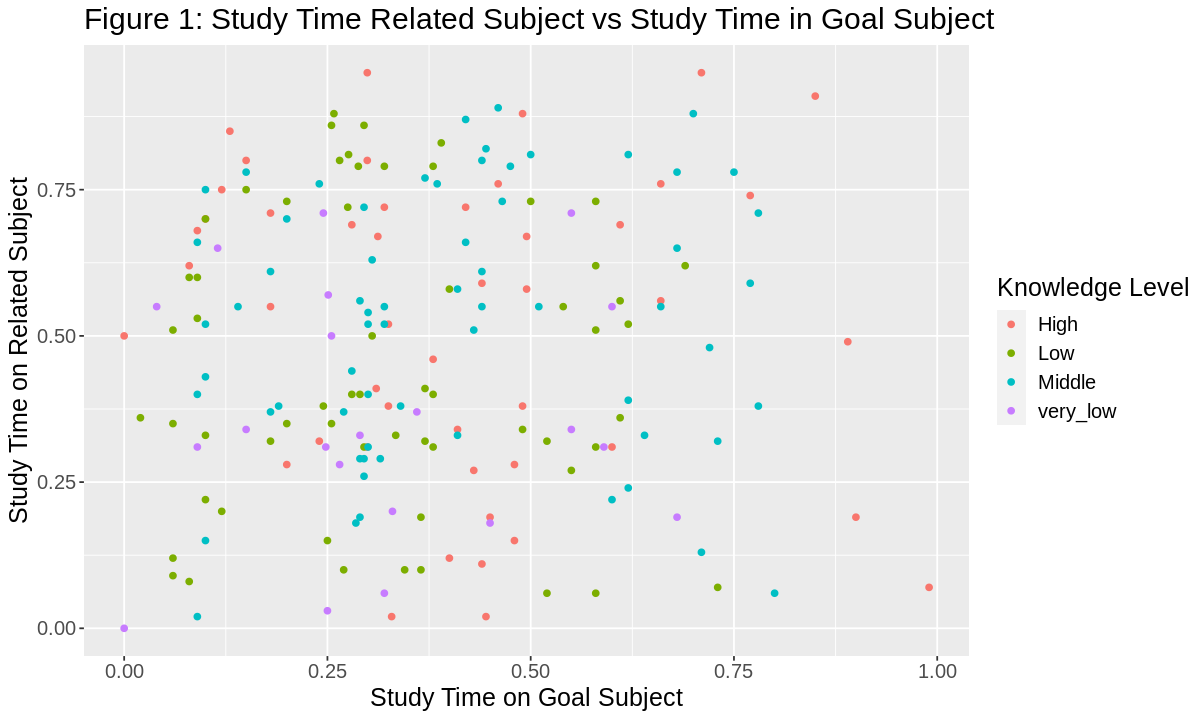

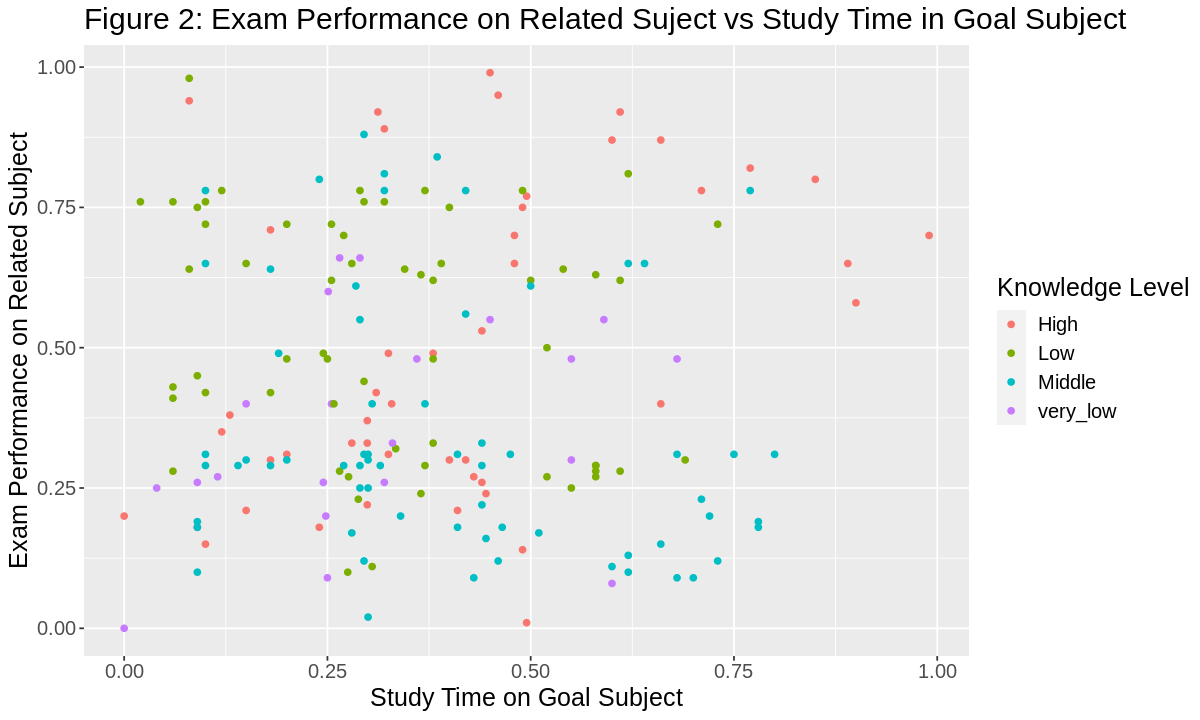

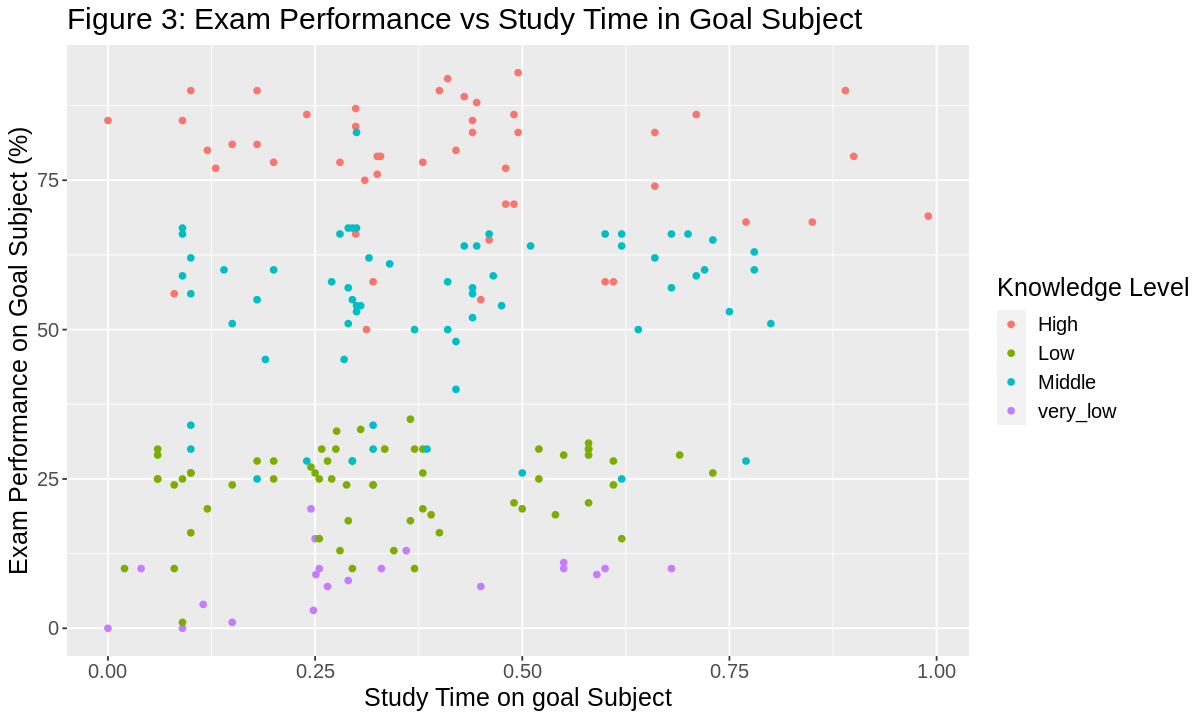

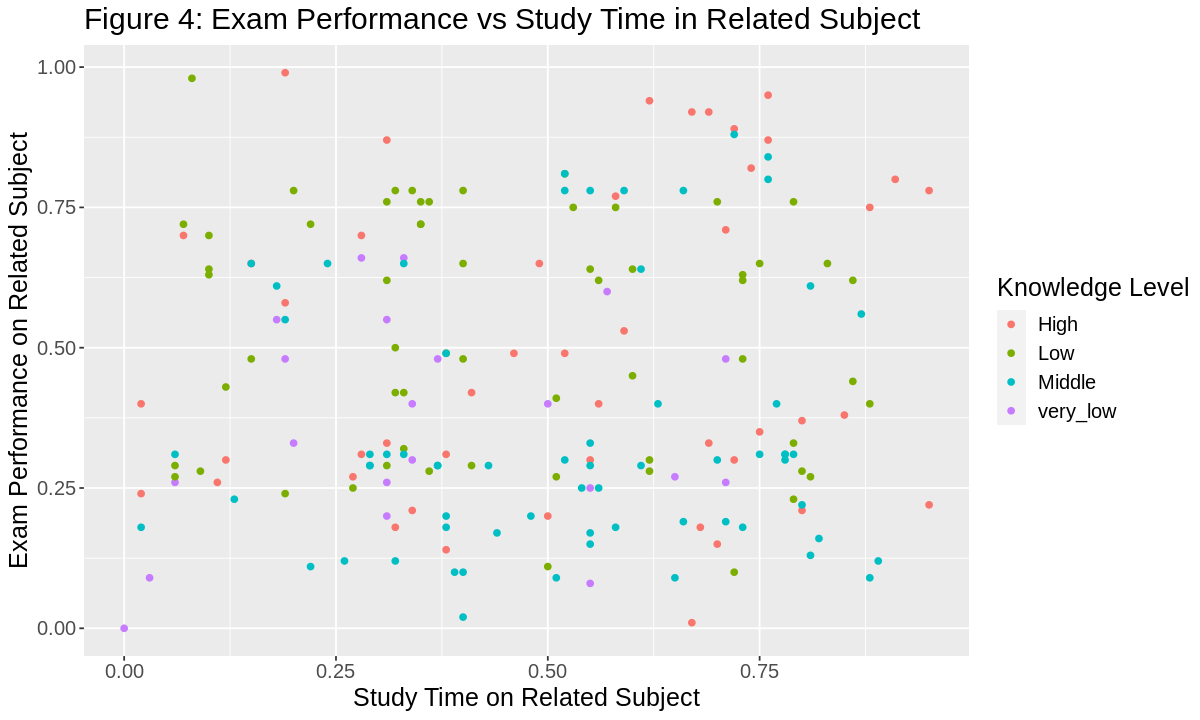

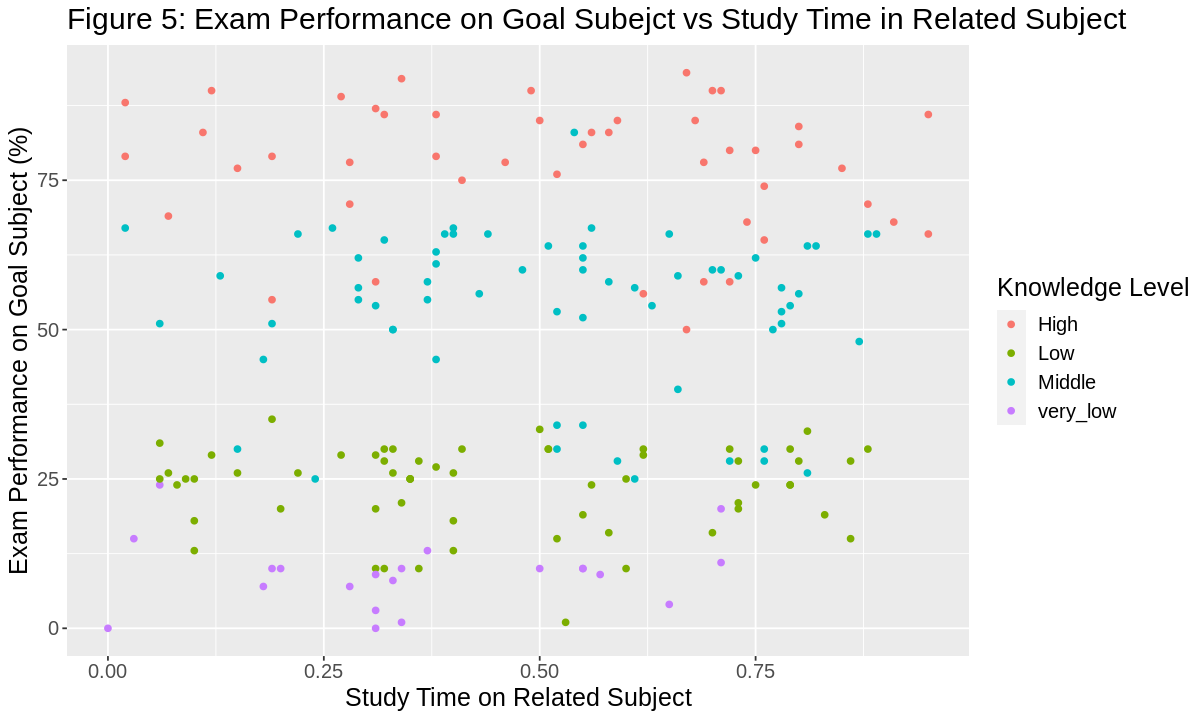

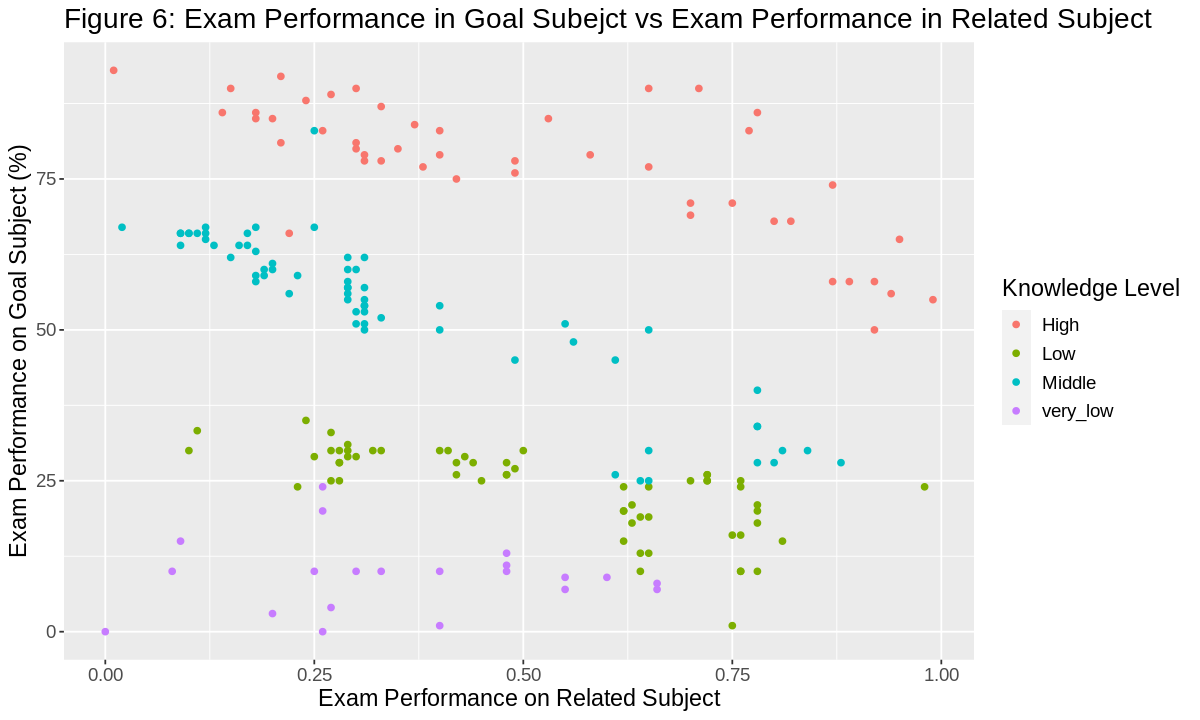

In [5]:
options(repr.plot.width=10, repr.plot.height=6)

plot_time_related_time <- student_train|>
    ggplot(aes(x = study_time, y = related_subject_time, colour = knowledge_level)) +
    geom_point() +
    labs(x = "Study Time on Goal Subject",
         y = "Study Time on Related Subject",
        colour = "Knowledge Level") +
    ggtitle("Figure 1: Study Time Related Subject vs Study Time in Goal Subject") +
     theme(text = element_text(size = 15))
plot_time_related_time

plot_time_related_perf <- student_train|>
    ggplot(aes(x = study_time, y = related_exam_performance, colour = knowledge_level)) +
    geom_point() +
    labs(x = "Study Time on Goal Subject",
         y = "Exam Performance on Related Subject",
        colour = "Knowledge Level") +
    ggtitle("Figure 2: Exam Performance on Related Suject vs Study Time in Goal Subject") +
     theme(text = element_text(size = 15))
plot_time_related_perf

plot_time_perf <- student_train|>
    ggplot(aes(x = study_time, y = exam_performance_percentage, colour = knowledge_level)) +
    geom_point() +
    labs(x = "Study Time on goal Subject",
         y = "Exam Performance on Goal Subject (%)",
        colour = "Knowledge Level") +
    ggtitle("Figure 3: Exam Performance vs Study Time in Goal Subject") +
     theme(text = element_text(size = 15))
plot_time_perf

plot_related_time_perf <- student_train|>
    ggplot(aes(x = related_subject_time, y = related_exam_performance, colour = knowledge_level)) +
    geom_point() +
    labs(x = "Study Time on Related Subject",
         y = "Exam Performance on Related Subject",
        colour = "Knowledge Level") +
    ggtitle("Figure 4: Exam Performance vs Study Time in Related Subject") +
     theme(text = element_text(size = 15))
plot_related_time_perf

plot_related_time_exam <- student_train|>
    ggplot(aes(x = related_subject_time, y = exam_performance_percentage, colour = knowledge_level)) +
    geom_point() +
    labs(x = "Study Time on Related Subject",
         y = "Exam Performance on Goal Subject (%)",
        colour = "Knowledge Level") +
    ggtitle("Figure 5: Exam Performance on Goal Subejct vs Study Time in Related Subject") +
     theme(text = element_text(size = 15))
plot_related_time_exam

plot_related_exam_perf <- student_train|>
    ggplot(aes(x = related_exam_performance, y = exam_performance_percentage, colour = knowledge_level)) +
    geom_point() +
    labs(x = "Exam Performance on Related Subject",
         y = "Exam Performance on Goal Subject (%)",
        colour = "Knowledge Level") +
    ggtitle("Figure 6: Exam Performance in Goal Subejct vs Exam Performance in Related Subject") +
     theme(text = element_text(size = 14))
plot_related_exam_perf

#### Method: Choosing Predictors

After looking at Table 3 and Figures 1-6 above, we decided to use study_time and exam_performance_percentage as our predictive variables in order to classify the new observations' knowledge_level. Using Table 3, we compared the mean values of our predictor variables at each knowledge level and identified differences in the data, which suggested that there was a significance to the groupings. In the exam performance and time spent studying columns the high and very_low knowledge levels had large discrepancies which suggests that these predictors have a significant impact in knowledge level. 

Whereas, in the related subject time column the mean for middle knowledge level is greater than the mean for the high knowledge level. Similarly, in the related exam performance column the mean for low knowledge level exam performance is greater than the mean for high knowledge level exam performance. Thus, the 2 columns regarding related subjects seem to have less of an impact on student knowledge level in our goal subject. 

Looking at Figures 1-6 that we made, the knowledge level has little overlap for exam performance graphed against any of the predictor variables. Therefore, it is a good predictor variable to use for the model. Looking at the other three predictors, there is a lot of overlap between knowledge levels for study time with related subject study time, and study time with related subject exam performance. Both related subject study time and exam performance also overlaps each other as well. Because we are more interested in understanding the study habits and how it is related to one goal subject, we decided that study time in our goal subject will be the second predictor variable we will use to build our classifier.

Thus, we tidied our summary table to only include the mean for the predictive variables we are interested in.

In [6]:
summarize_average <- student_average |>
    select(knowledge_level, study_time, exam_performance_percentage)

print("Table 4: Mean Values of our Predictive Variables According to Knowledge Level")
summarize_average

[1] "Table 4: Mean Values of our Predictive Variables According to Knowledge Level"


knowledge_level,study_time,exam_performance_percentage
<fct>,<dbl>,<dbl>
High,0.4130426,77.446809
Low,0.3255167,23.588333
Middle,0.4033846,53.676923
very_low,0.3156667,9.095238


#### Methods: Building the Model

Preprocessing our training data by creating a recipe, scaling our predictors, and creating our model specification.

In [7]:
set.seed(7)

student_recipe <- recipe(knowledge_level ~ study_time + exam_performance_percentage, data = student_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

student_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")


#### Methods

In order to choose the best K for our classification model, we then tuned our model and performed a 5-fold cross-validiation using K = 1-10. Then, we evaluated the accuracy of the different K's by plotting accuracy estimate vs the number of neighbors.

In [8]:
set.seed(7)

gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

student_vfold <- vfold_cv(student_train, v = 5, strata = knowledge_level)

student_results <- workflow() |>
    add_recipe(student_recipe) |>
    add_model(student_tune) |>
    tune_grid(resamples = student_vfold, grid = gridvals) |>
    collect_metrics()

print("Table 5: Evaluating the Accuracy of K")
accuracies <- student_results |> 
       filter(.metric == "accuracy")
accuracies

[1] "Table 5: Evaluating the Accuracy of K"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6992510,5,0.008033632,Preprocessor1_Model01
2,accuracy,multiclass,0.6992510,5,0.008033632,Preprocessor1_Model02
3,accuracy,multiclass,0.7779150,5,0.031467421,Preprocessor1_Model03
4,accuracy,multiclass,0.7831781,5,0.033430063,Preprocessor1_Model04
5,accuracy,multiclass,0.7829217,5,0.029265380,Preprocessor1_Model05
6,accuracy,multiclass,0.7776586,5,0.025674211,Preprocessor1_Model06
7,accuracy,multiclass,0.7723954,5,0.022743556,Preprocessor1_Model07
8,accuracy,multiclass,0.7723954,5,0.022743556,Preprocessor1_Model08
9,accuracy,multiclass,0.7723954,5,0.017592985,Preprocessor1_Model09


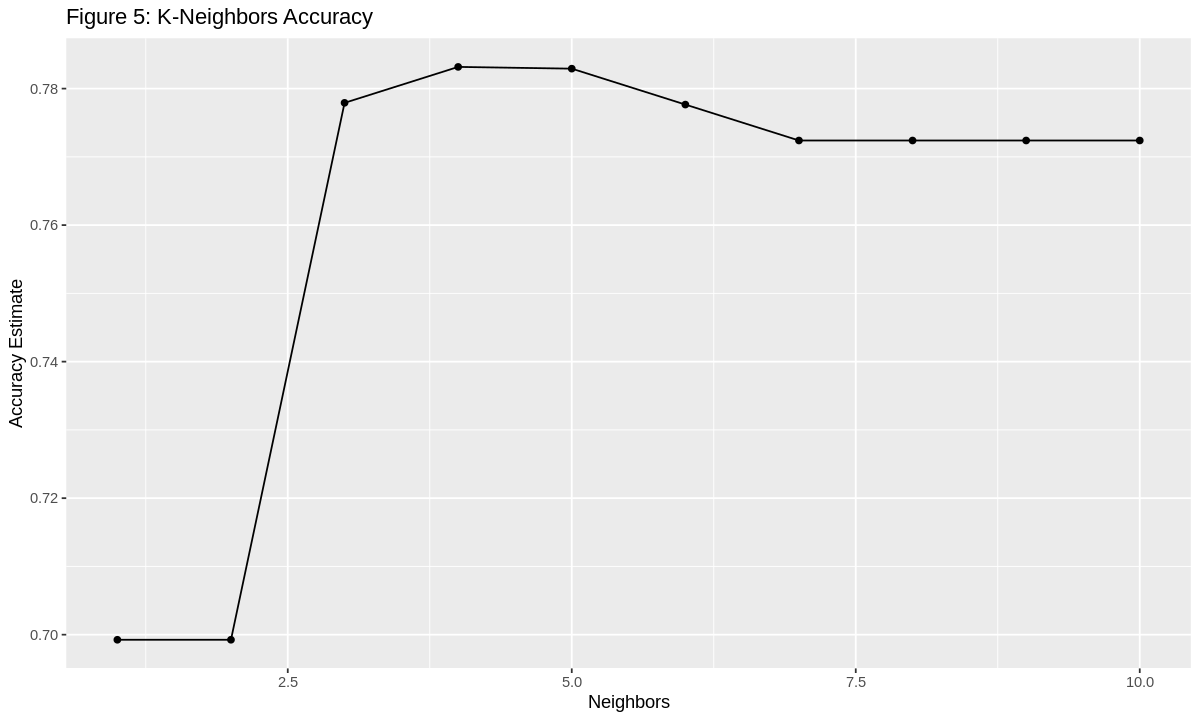

In [9]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Figure 5: K-Neighbors Accuracy")
accuracy_versus_k

#### Methods

Based on Table 5 and Figure 5, we found that when K = 4 neighbors, the accuracy estimate is the highest (0.7831781). Thus, for our model we selected K = 4.

We then performed our classification analysis on our testing data set (student_test) using K = 4 neighbors.  

In [10]:
set.seed(7)

student_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
    set_engine("kknn") |>
    set_mode("classification")

student_fit <- workflow() |>
    add_recipe(student_recipe) |>
    add_model(student_spec) |>
    fit(student_train)

student_predictions <- predict(student_fit, student_test) |>
    bind_cols(student_test) |>
    select(-related_subject_time, -related_exam_performance, -exam_performance) 

print("Table 6: First Six Rows of Predicted Data")
head(student_predictions)

print("Table 7: Last Six Rows of Predicted Data")
tail(student_predictions)

[1] "Table 6: First Six Rows of Predicted Data"


.pred_class,study_time,knowledge_level,exam_performance_percentage
<fct>,<dbl>,<fct>,<dbl>
High,0.08,High,90
Low,0.06,Low,33
Low,0.05,very_low,5
Middle,0.10,Low,33
Low,0.15,Low,29
Middle,0.20,Middle,56


[1] "Table 7: Last Six Rows of Predicted Data"


.pred_class,study_time,knowledge_level,exam_performance_percentage
<fct>,<dbl>,<fct>,<dbl>
Middle,0.52,Middle,52
Middle,0.64,Middle,63
High,0.91,High,88
Middle,0.72,Middle,45
High,0.56,Middle,50
High,0.54,High,77


#### Methods

We then computed the mean study time and mean exam performance for the predicted knowledge level class that was determined by our model on our testing data set. Table 8 shows that the highest mean study time and exam performance was categorized as high knowledge level, and similarly the lowest mean study time and exam performance was categorized as very low knowledge level.

In [11]:
student_predictions_average <- student_predictions |>
    group_by(.pred_class) |>
    summarize(avg_study_time = mean(study_time),
             avg_exam_performance = mean(exam_performance_percentage))

print("Table 8: Mean predictive variables according to predicted knowledge level")
student_predictions_average

[1] "Table 8: Mean predictive variables according to predicted knowledge level"


.pred_class,avg_study_time,avg_exam_performance
<fct>,<dbl>,<dbl>
High,0.4647143,78.07143
Low,0.3337083,24.29167
Middle,0.3651250,58.00000
very_low,0.2283333,9.00000


#### Methods: Accuracy and Confusion Matrix

Observing the metrics of our model including the accuracy of our model and the confusion matrix to see how many observations our model predicted correctly and incorrectly.

In [12]:
student_accrucy <- student_predictions|>
    metrics(truth = knowledge_level, estimate = .pred_class) |>
    filter(.metric == "accuracy")

print("Table 9: Accuracy and Confusion Matrix of Classification Model")
student_accrucy

student_conf <- student_predictions |>
     conf_mat(truth = knowledge_level, estimate = .pred_class)
student_conf

[1] "Table 9: Accuracy and Confusion Matrix of Classification Model"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8307692


          Truth
Prediction High Low Middle very_low
  High       13   0      1        0
  Low         0  20      2        2
  Middle      3   1     20        0
  very_low    0   2      0        1

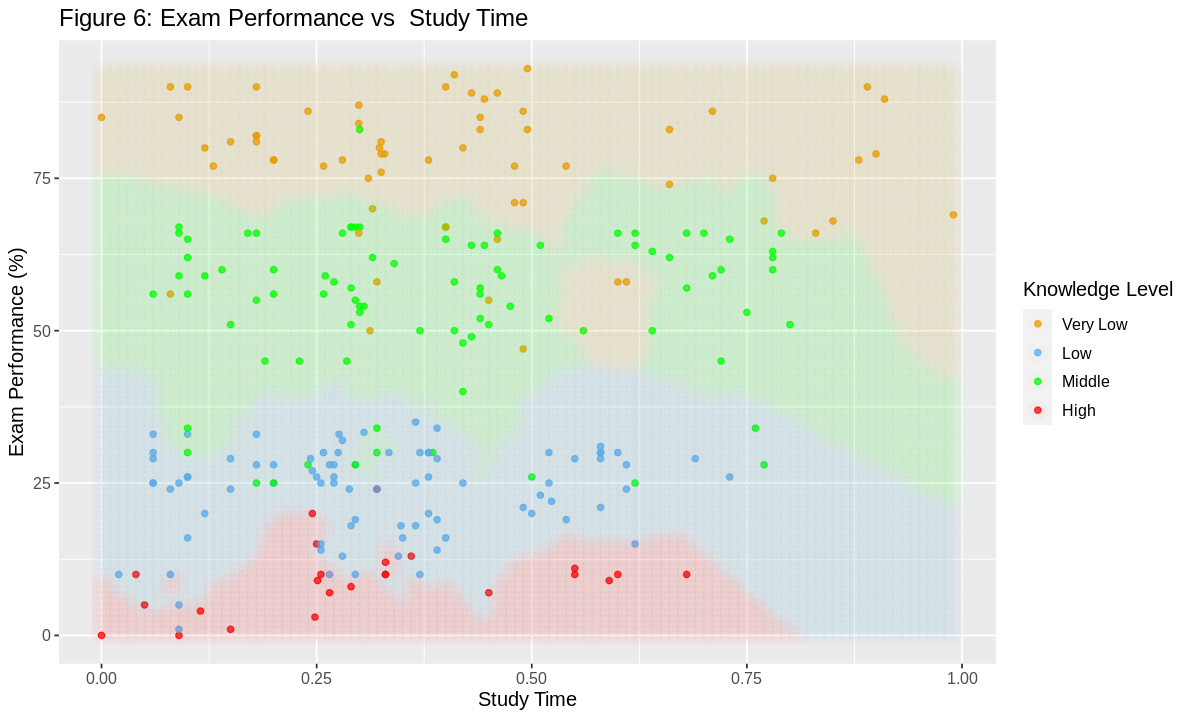

In [13]:
# create the grid of area/smoothness vals, and arrange in a data frame
time_grid <- seq(min(student_data$study_time), 
                max(student_data$study_time), 
                length.out = 100)
perf_grid <- seq(min(student_data$exam_performance_percentage), 
                max(student_data$exam_performance_percentage), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(study_time = time_grid, 
                                exam_performance_percentage = perf_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(student_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)

# plot:
wkflw_plot <-
  ggplot() +
  geom_point(data = student_data, 
             mapping = aes(x = study_time, 
                           y = exam_performance_percentage, 
                           color = knowledge_level), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = study_time, 
                           y = exam_performance_percentage, 
                           color = Class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Knowledge Level", 
       x = "Study Time", 
       y = "Exam Performance (%)") +
  scale_color_manual(labels = c("Very Low", "Low", "Middle", "High"), 
                     values = c("orange2", "steelblue2", "green", "red")) +
  theme(text = element_text(size = 12)) +
  ggtitle("Figure 6: Exam Performance vs  Study Time")

wkflw_plot

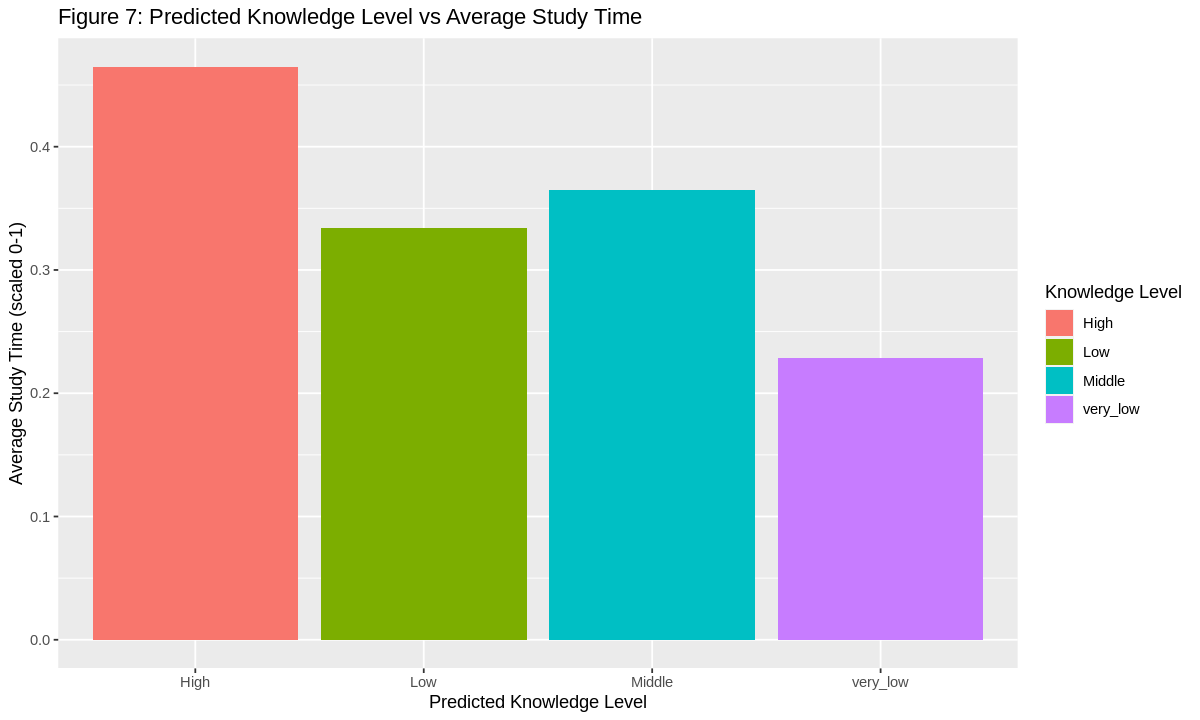

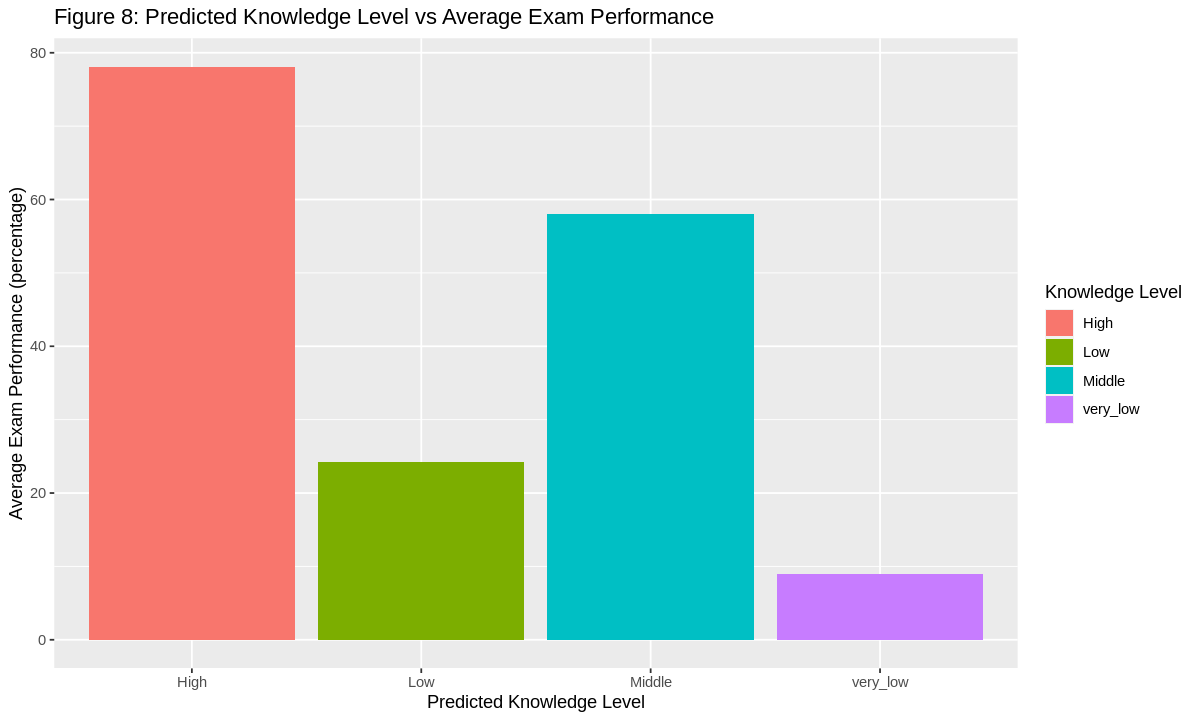

In [15]:
predicted_study_time <- student_predictions_average|>
    ggplot(aes(x = .pred_class, y = avg_study_time, fill = .pred_class)) +
    geom_bar(stat = "identity") +
    labs(x = "Predicted Knowledge Level",y = "Average Study Time (scaled 0-1)", fill = "Knowledge Level") +
    ggtitle("Figure 7: Predicted Knowledge Level vs Average Study Time")
predicted_study_time

predicted_exam_performance <- student_predictions_average|>
    ggplot(aes(x = .pred_class, y = avg_exam_performance, fill = .pred_class)) +
    geom_bar(stat = "identity") +
    labs(x = "Predicted Knowledge Level",y = "Average Exam Performance (percentage)", fill = "Knowledge Level") +
    ggtitle("Figure 8: Predicted Knowledge Level vs Average Exam Performance")
predicted_exam_performance

#### Interpretation of Results

The results of our visual analysis in figure 7 and 8 suggest that a high level of knowledge was associated with greater study times and higher average exam performance. This suggest that there is a positive relationship between UNS (user knowledge level) and both of variables STG (degree of study time for goal object materials), PEG (exam performance of user for goal objects) that were examined in our analysis. 

#### Discussion

From our analysis of the Electrical DC Machines User data set, we expected to find that greater exam performance and more studying time can predict higher student knowledge level. We tested our predictions via a k-nn classification model where k = 4. The accuracy of our model is 0.83, which shows that the prediction is largely in line with our expectations, so our classification model meets the requirement of our predictions. 

These findings can help students make effective learning strategies, for example, if students try to allocate more time to effective study time and improving their exam grades it should correlate to a higher level of knowledge. Moreover, even though we have found the result, we still have enthusiasm to find if there are more accurate ways to track study time. Some underlying questions that we still have include: “How would other study habits such as attendance and other factors have an impact on knowledge levels?” and “How would the knowledge level results differ in other classes such as biology?”. For these two questions, we can make more classification models to predict and explore the results. 

For our analysis, although study time may benefit knowledge level, in our graphs we see that high and middle knowledge levels have about the same average study time. So another question that we can further explore is "What is the best way to spend study time in order to optimize time and benefit knowledge level?". We believe that these further questions will be answered in the future and can further help students excel in their learning.

#### References

Kahraman, Hamdi, Colak, Ilhami, and Sagiroglu, Seref. (2013). User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.

Jafari H, Aghaei A, Khatony A. Relationship between study habits and academic achievement in students of medical sciences in Kermanshah-Iran. Adv Med Educ Pract. 2019 Aug 15; 10:637-643. doi: 10.2147/AMEP.S208874.

Cambridge Dictionary. “KNOWLEDGE | Meaning in the Cambridge English Dictionary.” Cambridge.org, Cambridge University Press, 2019, dictionary.cambridge.org/dictionary/english/knowledge.
